In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from matplotlib import pyplot as plt

### system imports 

In [66]:
import pathlib
import sys
import os 
import time 
import pickle
import time 
from datetime import timedelta
from functools import partial

### get current directory 


In [6]:
CWD = pathlib.Path.cwd()

In [7]:
HOME = pathlib.Path.home()

### add the path to the custom functions

In [8]:
sys.path.append(str(HOME.joinpath('research/dl4seas/dl4seas/')))

In [9]:
from NN import *
from utils import *

### Scientific Stack 

In [10]:
import numpy as np 
import pandas as pd 
import xarray as xr

### Tensorflow and Keras 

In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

### set the random seeds for reproducible results 

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

### check if the GPU is available 

In [13]:
if len(tf.config.list_physical_devices('GPU')) >= 1: 
    compute = 'GPU'
else: 
    compute = 'CPU'

In [14]:
compute

'GPU'

### Loads and prepare the data 

In [23]:
dpath_vcsn = '/media/nicolasf/END19101/data/VCSN/'
dpath_gcm = '/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/T2M/'

### target (VCSN)

In [24]:
var_name = "TMEAN"

In [25]:
if "TMEAN" in var_name:
    dpath = pathlib.Path(f"{dpath_vcsn}/{var_name.replace('_N','')}/seasonal_anomalies_VCSN_{var_name}_N.nc")
elif "RAIN" in var_name:
    dpath = pathlib.Path(f"{dpath_vcsn}/{var_name.replace('_BC','')}/seasonal_anomalies_VCSN_{var_name}_BC.nc")

In [26]:
vcsn = xr.open_dataset(dpath) 

In [27]:
vcsn = vcsn[['Tmean_N']]

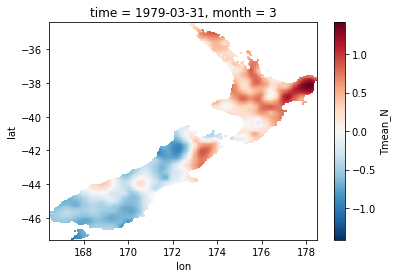

In [28]:
vcsn.isel(time=0)['Tmean_N'].plot()

### read the GCM data 

In [29]:
dpath_gcm

'/media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/T2M/'

In [ ]:
CDS_ECMWF_T2M_2019-12_seasonal_anomalies_interp_1993_2016_clim.nc

In [32]:
lfiles = list_files(dpath_gcm, pattern="CDS_ECMWF_T2M*seasonal_anomalies*1981_2010*", extension=".nc", exclude='interp', verbose=1)

loaded files, list length 468
the first file is /media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/T2M/CDS_ECMWF_T2M_1981-01_seasonal_anomalies_1981_2010_clim.nc
the last file is /media/nicolasf/END19101/data/GCMs/processed/CDS/ECMWF/T2M/CDS_ECMWF_T2M_2019-12_seasonal_anomalies_1981_2010_clim.nc


### read the multiple files data set using xarray and dask, not that it will not be loaded in RAM

In [38]:
gcm = xr.open_mfdataset(lfiles, concat_dim='init_time', combine='nested', parallel=True)

In [39]:
gcm.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (init_time: 468, lat: 181, lon: 360, member: 25, step: 4)
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * step       (step) int64 2 3 4 5
  * member     (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * init_time  (init_time) datetime64[ns] 1981-01-01 1981-02-01 ... 2019-12-01
    month      (init_time) int64 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    t2m        (init_time, step, member, lat, lon) float32 dask.array<chunksize=(1, 4, 25, 181, 360), meta=np.ndarray>>

### selects the training set 

In [40]:
gcm_train = gcm.sel(init_time=slice('1981','2010'))

### selects the validation set 

In [41]:
gcm_val = gcm.sel(init_time=slice('2011','2015'))[['t2m']]

### keep one year for testing 

In [42]:
gcm_test = gcm.sel(init_time='2016')[['t2m']]

**prepare the data**: 
    
    1) select the step (leadtime)
    2) to increase the size of the training and validation sets, consider each member as an instance (stacking along the time and member dimension)
    3) transpose to have the instances as the first dimension

In [43]:
def prep_data(ds): 
    ds = ds[['t2m']].sel(step=3)
    ds = ds.stack(instance=('init_time','member'))
    ds = ds.transpose('instance','lat','lon')
    return ds

In [44]:
gcm_train, gcm_val, gcm_test = map(prep_data, [gcm_train, gcm_val, gcm_test])

In [45]:
gcm_train

,Array,Chunk
Bytes,2.35 GB,6.52 MB
Shape,"(9000, 181, 360)","(25, 181, 360)"
Count,3672 Tasks,360 Chunks
Type,float32,numpy.ndarray


In [46]:
rdatetimes_train = gcm_train.indexes["instance"].get_level_values(0)

In [47]:
rdatetimes_val = gcm_val.indexes["instance"].get_level_values(0)

In [48]:
rdatetimes_test = gcm_test.indexes["instance"].get_level_values(0)

In [55]:
from dateutil.relativedelta import relativedelta

In [62]:
def shift_gcm_time(time, step=3): 
    time = [x + relativedelta(months=step) for x in time]
    return time

In [65]:
rdatetimes_train, rdatetimes_val, rdatetimes_test = map(partial(shift_gcm_time, step=3), [rdatetimes_train, rdatetimes_val, rdatetimes_test])

### shift the VCSN time 

In [68]:
vcsn.time[0]

<xarray.DataArray 'time' ()>
array('1979-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1979-03-31
    month    int64 ...

In [69]:
vcsn.time[-1]

<xarray.DataArray 'time' ()>
array('2019-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-12-31
    month    int64 ...

In [70]:
vcsn['time'] = shift_time(vcsn.time.to_index(), shift='Month Begin')

In [71]:
vcsn.time[0]

<xarray.DataArray 'time' ()>
array('1979-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1979-03-01
    month    int64 ...

In [72]:
vcsn['time'][-1]

<xarray.DataArray 'time' ()>
array('2019-12-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-12-01
    month    int64 ...

In [73]:
vcsn_train = vcsn.sel(time=rdatetimes_train)

In [74]:
vcsn_val = vcsn.sel(time=rdatetimes_val)

In [75]:
vcsn_test = vcsn.sel(time=rdatetimes_test)

### rename 'time' to 'instance' in vcsn

In [76]:
vcsn_train, vcsn_val, vcsn_test = map(lambda x: x.rename({'time':'instance'}), [vcsn_train, vcsn_val, vcsn_test])

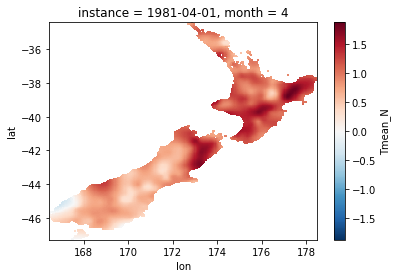

In [77]:
vcsn_train.isel(instance=0)['Tmean_N'].plot()

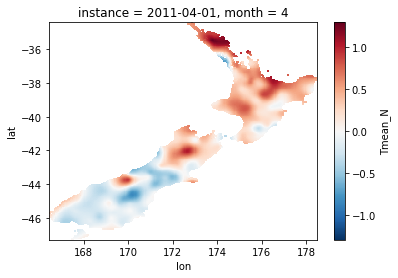

In [78]:
vcsn_val.isel(instance=0)['Tmean_N'].plot()

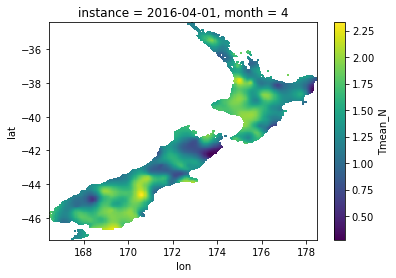

In [79]:
vcsn_test.isel(instance=0)['Tmean_N'].plot()

### Now checks if everything is OK 

In [80]:
gcm_train.dims

Frozen(SortedKeysDict({'lat': 181, 'lon': 360, 'instance': 9000}))

In [81]:
vcsn_train.dims

Frozen(SortedKeysDict({'lat': 257, 'lon': 241, 'instance': 9000}))

### define the parameters for the model

In [82]:
batch_size = 32

### preparing the data

#### not that it takes ages because of the repeated instances, maybe write a more general DataGenerator Class that just takes the already transformed xarray datasets ... 

In [83]:
data_train = XrDataGenerator(gcm_train, vcsn_train, {'t2m':None}, 'Tmean_N', \
                             norm=True, batch_size=batch_size, \
                             mean=None, std=None, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

In [84]:
data_val = XrDataGenerator(gcm_val, vcsn_val, {'t2m':None}, 'Tmean_N', \
                           norm=True, batch_size=batch_size, \
                           mean=data_train.mean, std=data_train.std, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

In [85]:
data_test = XrDataGenerator(gcm_test, vcsn_test, {'t2m':None}, 'Tmean_N', \
                            norm=True, batch_size=batch_size, \
                            mean=data_train.mean, std=data_train.std, shuffle=True, load=False, Y_flatten=True, Y_dropna=True)

### checks the shapes 

In [86]:
data_train[0][0].shape

(32, 181, 360, 1)

In [87]:
data_train[0][1].shape

(32, 11491, 1)

In [88]:
data_val[0][0].shape

(32, 181, 360, 1)

In [89]:
data_val[0][1].shape

(32, 11491, 1)

In [90]:
data_test[0][0].shape

(32, 181, 360, 1)

In [91]:
data_test[0][1].shape

(32, 11491, 1)

### Parameters for the model 

#### batch size 

In [92]:
batch_size = 32

#### padding 

In [93]:
padd = 8

#### input shape (latitudes, longitudes, 1)

In [94]:
input_shape = (181, 360, 1)

#### calculate the resized shape

convolutional layers are usually paired with pooling layers, and an autoencoder 
using pooling and upsampling requires input dimensions (lat and lon) which divides exactly by the amount of pooling, in some other experiments I used 3 2x2 pooling layers, 
so needed the grid dimensions in lat and lon to be divisible by 8 (2^3). I kept that here ..

In [95]:
resize_shape = (padd * round(input_shape[0]/padd), padd * round(input_shape[1]/padd))

In [96]:
resize_shape

(184, 360)

#### number of epochs 

In [97]:
n_epochs = 20

### build the model from scratch 

In [98]:
# %% Input
original = Input(shape=input_shape)

# Resize to have dimensions divisible by 8 (the padding)
resized = ResizeLayer(newsize=resize_shape)(original)

# # Wrap-around in longitude for periodic boundary conditions

padded = PeriodicPadding2D(padd)(resized)

# Encoding layers
x = Conv2D(16, (3, 3), padding='same')(padded)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)
x = Conv2D(8, (3, 3), strides= (2,2), padding='valid')(x)
x = LeakyReLU()(x)

encoded = x 

### Flatten 

In [99]:
encoded = Flatten(input_shape=[49,93,8])(encoded)

### build the stack of dense layers 

In [100]:
x = Dense(1000, input_shape=[np.prod([49,93,8])])(encoded)
x = LeakyReLU()(x)
x = Dense(5000)(x)
x = LeakyReLU()(x)

output = Dense(11491)(x)

In [101]:
model = Model(original,output)

In [102]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 181, 360, 1)]     0         
_________________________________________________________________
resize_layer (ResizeLayer)   (None, 184, 360, 1)       0         
_________________________________________________________________
periodic_padding2d (Periodic (None, 200, 376, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 376, 16)      160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200, 376, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 187, 8)        1160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 99, 187, 8)        0     

In [103]:
model.compile(optimizer='adam', loss='mean_squared_error') 

In [104]:
n_epochs = 20

In [105]:
history = model.fit(data_train, validation_data=data_val, epochs=n_epochs) 

Epoch 1/20
282/282 [==============================] - 74s 262ms/step - loss: 0.2873 - val_loss: 0.3967
Epoch 2/20
282/282 [==============================] - 69s 244ms/step - loss: 0.0881 - val_loss: 0.3927
Epoch 3/20
282/282 [==============================] - 68s 241ms/step - loss: 0.0380 - val_loss: 0.4085
Epoch 4/20
282/282 [==============================] - 69s 245ms/step - loss: 0.0215 - val_loss: 0.4082
Epoch 5/20
282/282 [==============================] - 69s 246ms/step - loss: 0.0143 - val_loss: 0.4188
Epoch 6/20
282/282 [==============================] - 70s 247ms/step - loss: 0.0110 - val_loss: 0.4104
Epoch 7/20
282/282 [==============================] - 70s 248ms/step - loss: 0.0105 - val_loss: 0.3963
Epoch 8/20
282/282 [==============================] - 70s 249ms/step - loss: 0.0088 - val_loss: 0.4179
Epoch 9/20
282/282 [==============================] - 71s 252ms/step - loss: 0.0090 - val_loss: 0.4078
Epoch 10/20
282/282 [==============================] - 71s 253ms/step - l

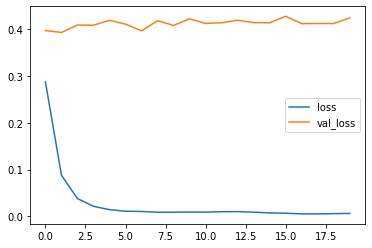

In [106]:
pd.DataFrame(history.history).plot()

In [107]:
preds_val = model.predict(data_val[0][0])

In [108]:
preds_val.shape

(32, 11491)

In [109]:
data_val[0][1].shape

(32, 11491, 1)

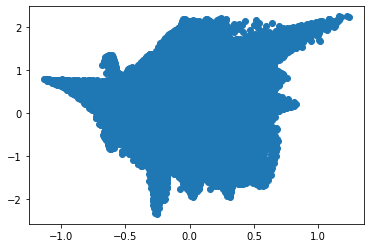

In [110]:
plt.scatter(preds_val.ravel(), data_val[0][1].ravel())

In [227]:
instance = 30

In [228]:
vcsn_val_inst = vcsn_val.isel(instance=instance)

In [229]:
vcsn_val_inst

<xarray.Dataset>
Dimensions:   (lat: 257, lon: 241)
Coordinates:
    month     int64 ...
  * lat       (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
    instance  datetime64[ns] 2011-02-01
  * lon       (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    Tmean_N   (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [230]:
vcsn_val_inst_stack = vcsn_val_inst.stack(z=('lat','lon'))

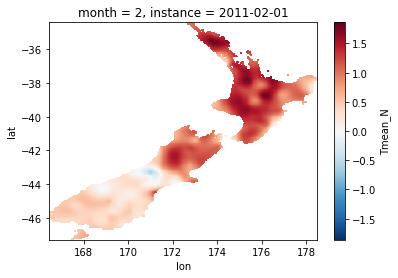

In [231]:
vcsn_val_inst_stack.unstack()['Tmean_N'].plot()

In [232]:
data = vcsn_val_inst_stack['Tmean_N'].data

In [233]:
pred_inst = preds_val[instance,]

In [234]:
pred_inst.shape

(11491,)

In [235]:
datac = data.copy()

In [236]:
datac[~np.isnan(datac)] = pred_inst

In [237]:
vcsn_val_inst_stack['Tmean_N_pred'] = (('z'), datac)

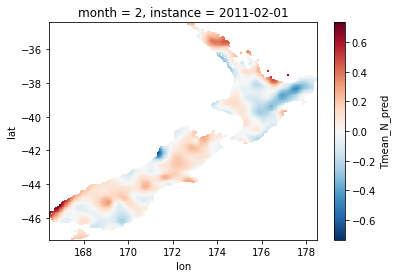

In [238]:
vcsn_val_inst_stack.unstack()['Tmean_N_pred'].plot()